In [3]:
# JUPYTER NOTEBOOK SETTINGS
from IPython.core.display import display, HTML
import random
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))
display(HTML("<style>table {float:left}</style>"))
import warnings
warnings.filterwarnings('ignore')
import matplotlib
%matplotlib inline
%config Completer.use_jedi = False

In [4]:
# LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import statsmodels
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

random_state = 123
np.random.seed(random_state)

# Newset Datathon

### Problem Definition
**Target:** `Earlies_Exp` - `MNR_SNR_Exp`

**Metric:** RMSE

### Importing Data

In [5]:
raw_train_data = pd.read_csv('data/train_data.csv')
raw_test_data = pd.read_csv('data/test.csv')
raw_train_data.head()

,ofd_date,country_code,fc_codes,station_code,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline
0,2021-06-30,C,"F6, F8, F14, F17",D33,14594,14568,782,896,615,767,35,2,4
1,2021-06-30,C,"F6, F8, F9, F14, F17, F18",D37,12736,13111,655,823,211,29,17,2,1
2,2021-06-30,C,"F1, F4, F6, F7, F13, F15, F16",D34,14562,15651,1028,1910,225,35,47,3,1
3,2021-06-30,C,"F2, F6, F7, F10, F12, F13, F14, F15, F19",D45,11165,11467,514,769,56,39,29,0,1
4,2021-06-30,C,"F6, F8, F13, F14, F17",D50,10006,10423,399,842,52,60,65,1,1


In [6]:
raw_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11309 entries, 0 to 11308
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ofd_date      11309 non-null  object
 1   country_code  11309 non-null  object
 2   fc_codes      11309 non-null  object
 3   station_code  11309 non-null  object
 4   OFD           11309 non-null  int64 
 5   Slam          11309 non-null  int64 
 6   Earlies_Exp   11309 non-null  int64 
 7   Earlies_Rec   11309 non-null  int64 
 8   MNR_SNR_Exp   11309 non-null  int64 
 9   Rollover      11309 non-null  int64 
 10  Returns       11309 non-null  int64 
 11  R_Sideline    11309 non-null  int64 
 12  Sideline      11309 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


In [ ]:
# report = ProfileReport(raw_train_data, minimal=True)
# report

#### Submission Format

In [9]:
submission = pd.read_csv('data/SampleSubmission.csv')
submission

,Id,Expected
0,2021-07-31_D33,200
1,2021-07-31_D37,281
2,2021-07-31_D34,312
3,2021-07-31_D45,44
4,2021-07-31_D50,-20
...,...,...
2384,2021-07-01_D60,-161
2385,2021-07-01_D54,140
2386,2021-07-01_D69,-86
2387,2021-07-01_D59,-44


In the submission there are some missing stations for some dates...

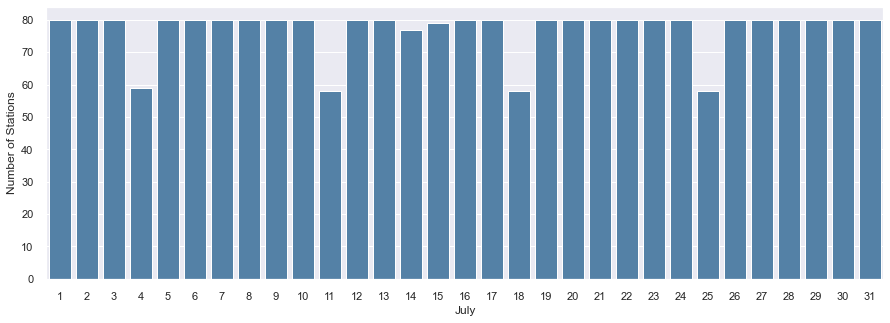

In [84]:
station_count = pd.DataFrame(list(submission.Id.str.split('_')), columns=['date','station']).groupby('date', as_index=False).agg('count')
station_count['date'] = pd.to_datetime(station_count.date, format='%Y-%m-%d').dt.day

sns.set()
ax, fig = plt.subplots(figsize=(15,5))
sns.barplot(data=station_count, x='date', y='station', color='steelblue')
plt.xlabel('July')
plt.ylabel('Number of Stations');

### Data Issues
- `OFD` is combination of other variables and also includes part of the target variable so it cannot be used.
- Incorrect data types (`ofd_date`)
- What to do with `fc_codes` variable? One-hot-encode or aggregate or drop?
- High amount of zeros in `R_Sideline` and `Sideline`

### Data Preprocessing
Please create a function for each step to be able to apply it to both train and test set easily and use doc strings to describe what the function does.

In [60]:
def set_data_types(data):
    '''Changes data types to correct type.'''
    
    data['ofd_date'] = pd.to_datetime(data.ofd_date, format='%Y-%m-%d')
    return data


def drop_useless(data):
    '''Drops unneed variables.'''
    
    data = data.drop(['OFD'],axis=1)
    return data


def create_target(data):
    '''Creates target variable (Earlies_Exp - MNR_SNR_Exp) and drops those variables.'''
    
    data['target'] = data['Earlies_Exp'] - data['MNR_SNR_Exp']
    data = data.drop(['Earlies_Exp','MNR_SNR_Exp'], axis=1)
    return data


def apply_preprocessing(data, train=True):
    '''Takes all basic preprocessing functions and applies them in one function. Set train to false for test set as no target can be created.'''
    
    data = set_data_types(data)
    data = drop_useless(data)
    if train:
        data = create_target(data)
    return data

In [61]:
train_data = apply_preprocessing(raw_train_data)
test_data = apply_preprocessing(raw_test_data, train=False)

### Exploratory Data Analysis

All of the stations combined:

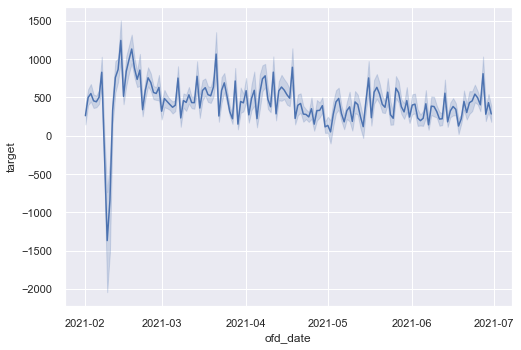

In [62]:
sns.set()
sns.lineplot(data=train_data, x='ofd_date', y='target');

Just station 1 as an example:

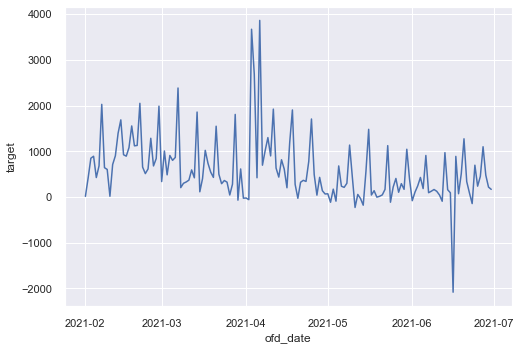

In [63]:
sns.lineplot(data=train_data[train_data.station_code=='D1'], x='ofd_date', y='target');

#### Taking care of outliers

This will have to be done individually for all 80 timeseries but based on the same rule like all outliers that are 3 standard deviations away from the mean or so...

### Base Model: Seasonal Naive

In [ ]:
results = pd.DataFrame()

In [ ]:
for station in train_data.station_code:
    